In [11]:
import time
import datetime
from pathlib import Path
from collections import Counter
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scipy import ndimage

from model import conv_block
from data import example_to_tensor, normalize, add_channel_axis, train_test_split
from plot import plot_slice, plot_animated_volume, grid_plot_slices
from config import data_root_dir, seed

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [26]:
tf.random.set_seed(seed)

input_shape = (48, 256, 256, 1)
neg_tfrecord_glob = "covid-neg/*.tfrecord"
pos_tfrecord_glob = "covid-pos/*.tfrecord"
# neg_tfrecord_glob = "CT-0/*.tfrecord"
# pos_tfrecord_glob = "CT-[1-4]/*.tfrecord"

epochs = 1000
patience = 30
batch_size = 8
learning_rate = 0.00001
dropout_rate = 0.5
val_perc = 0.12  # percentage from the already splitted training test
test_perc = 0.1

In [21]:
neg_tfrecord_fnames = [str(p) for p in Path(data_root_dir).glob(neg_tfrecord_glob)]
neg_x = (
    tf.data.TFRecordDataset(neg_tfrecord_fnames)
    .map(example_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(random_gaussian_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(add_channel_axis, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)
# num_neg = sum(1 for _ in neg_x)
num_neg = 250
# num_neg = 254
print(f"Number of negative samples: {num_neg}")
neg_x

Number of negative samples: 250


<ParallelMapDataset shapes: (48, 256, 256, 1), types: tf.float32>

In [4]:
pos_tfrecord_fnames = [str(p) for p in Path(data_root_dir).glob(pos_tfrecord_glob)]
pos_x = (
    tf.data.TFRecordDataset(pos_tfrecord_fnames)
    .map(example_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(add_channel_axis, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)
# num_pos = sum(1 for _ in pos_x)
num_pos = 250
# num_pos = 856
print(f"Number of positive samples: {num_pos}")
pos_x

Number of positive samples: 250


<ParallelMapDataset shapes: (None, None, None, 1), types: tf.float32>

In [23]:
neg_y = tf.data.Dataset.from_tensors(tf.constant([0], dtype=tf.int8)).repeat(num_neg)
neg_dataset = tf.data.Dataset.zip((neg_x, neg_y))
neg_dataset

<ZipDataset shapes: ((48, 256, 256, 1), (1,)), types: (tf.float32, tf.int8)>

In [24]:
pos_y = tf.data.Dataset.from_tensors(tf.constant([1], dtype=tf.int8)).repeat(num_pos)
pos_dataset = tf.data.Dataset.zip((pos_x, pos_y))
pos_dataset

<ZipDataset shapes: ((None, None, None, 1), (1,)), types: (tf.float32, tf.int8)>

In [27]:
@tf.function
def random_rotate(volume, label):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        angle = tf.random.uniform(minval=-180, maxval=180, dtype=tf.int32)
        volume = ndimage.rotate(volume, angle, axes=(1, 2), reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume, label

In [28]:
@tf.function
def random_gaussian_noise(x):
    x = x + tf.random.normal(input_shape[:-1], mean=0.0, stddev=0.1, dtype=tf.float32)
    x = tf.clip_by_value(x, 0, 1)
    return x

In [29]:
dataset = neg_dataset.concatenate(pos_dataset)
dataset, test_dataset = train_test_split(
    dataset,
    test_perc=test_perc,
    cardinality=(num_pos + num_neg),
    seed=seed,
)
test_dataset = test_dataset.batch(1)
train_dataset, val_dataset = train_test_split(
    dataset,
    test_perc=val_perc,
    cardinality=None,
    seed=seed,
)
val_dataset = (
    val_dataset.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset = (
    train_dataset.map(random_rotate, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(random_gaussian_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .cache()  # must be called before shuffle
    .shuffle(buffer_size=64, reshuffle_each_iteration=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
train_dataset

TypeError: in user code:


    TypeError: tf__random_gaussian_noise() takes 1 positional argument but 2 were given


In [ ]:
def count_labels(dataset):
    "Return a dictionary of the label count."
    return dict(Counter(label.numpy()[0] for _, label in dataset.unbatch()))


print(f"Train labels:\n\t{count_labels(train_dataset)}")
print(f"Validation labels:\n\t{count_labels(val_dataset)}")
print(f"Test labels:\n\t{count_labels(test_dataset)}")

In [ ]:
autoencoder = keras.models.load_model("models/autoencoder-20201103-111931.h5")
encoder = autoencoder.get_layer("encoder")
encoder.summary()
autoencoder.get_layer("decoder").summary()
autoencoder.summary()

In [20]:
original, y = next(iter(train_dataset.unbatch().batch(1)))
print(f"label: {y}")
encoder_out = autoencoder.get_layer("encoder")(original, training=False)
decoder_out = autoencoder.get_layer("decoder")(encoder_out, training=False)

label: [[1]]


In [21]:
plot_animated_volume(original[0, :])

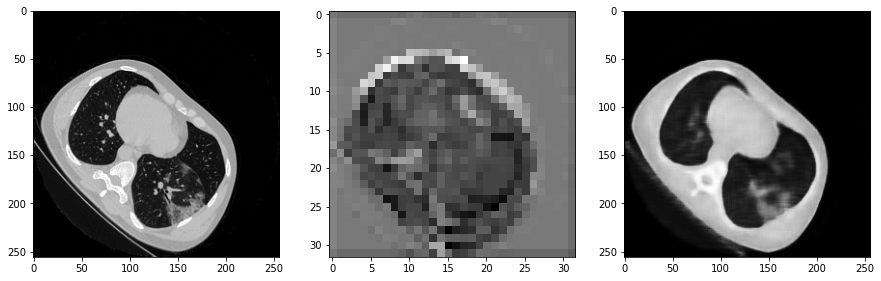

In [25]:
z_index = 18
fig, ax = plt.subplots(ncols=3)
plot_slice(original[0, :], z_index, ax[0])
plot_slice(encoder_out[0, :], 0, ax[1])
plot_slice(decoder_out[0, :], z_index, ax[2])

In [26]:
encoder.trainable = False
cnn = keras.Sequential(
    [
        encoder,
        keras.layers.Flatten(),
        keras.layers.Dense(
            512, activation="relu",
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="3dcnn",
)
cnn.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 6, 32, 32, 128)    277568    
_________________________________________________________________
flatten_1 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               402653696 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 402,931,777
Trainable params: 402,654,209
Non-trainable params: 277,568
_________________________________________________________________


In [27]:
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        # keras.metrics.TruePositives(name="tp"),
        # keras.metrics.FalsePositives(name="fp"),
        # keras.metrics.TrueNegatives(name="tn"),
        # keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
        # keras.metrics.Precision(name="precision"),
        # keras.metrics.Recall(name="recall"),
        # keras.metrics.AUC(name="auc"),
    ],
)

In [ ]:
monitor_metric = "val_accuracy"

start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
best_checkpoint = f"models/tl-{start_time}.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    best_checkpoint, monitor=monitor_metric, mode="max", verbose=1, save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor=monitor_metric, patience=patience, mode="max"
)
log_dir = f"logs/tl-{start_time}"
file_writer = tf.summary.create_file_writer(log_dir)
with file_writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"{seed=}; "
        f"{input_shape=}; "
        f"{epochs=}; "
        f"{patience=}; "
        f"{batch_size=}; "
        f"{learning_rate=}; "
        f"{dropout_rate=}; "
        f"{val_perc=}; "
        f"{test_perc=}",
        step=0,
    )
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=False,
    profile_batch=0,
)
cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)
cnn = keras.models.load_model(best_checkpoint)

Epoch 1/1000
     50/Unknown - 8s 159ms/step - loss: 2.6513 - accuracy: 0.5126
Epoch 00001: val_accuracy improved from -inf to 0.57407, saving model to models/tl-20201103-164835.h5
50/50 [==============================] - 468s 9s/step - loss: 2.6513 - accuracy: 0.5126 - val_loss: 1.9730 - val_accuracy: 0.5741
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.9832 - accuracy: 0.6212
Epoch 00002: val_accuracy improved from 0.57407 to 0.61111, saving model to models/tl-20201103-164835.h5
50/50 [==============================] - 471s 9s/step - loss: 0.9832 - accuracy: 0.6212 - val_loss: 0.8941 - val_accuracy: 0.6111
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.6180 - accuracy: 0.6793
Epoch 00003: val_accuracy improved from 0.61111 to 0.70370, saving model to models/tl-20201103-164835.h5
50/50 [==============================] - 469s 9s/step - loss: 0.6180 - accuracy: 0.6793 - val_loss: 0.5903 - val_accuracy: 0.7037
Epoch 4/1000
50/50 [=======

50/50 [==============================] - 39s 770ms/step - loss: 0.0724 - accuracy: 0.9949 - val_loss: 0.9342 - val_accuracy: 0.6296
Epoch 30/1000
50/50 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9798
Epoch 00030: val_accuracy did not improve from 0.70370
50/50 [==============================] - 39s 770ms/step - loss: 0.0907 - accuracy: 0.9798 - val_loss: 0.7937 - val_accuracy: 0.6296
Epoch 31/1000
50/50 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9848
Epoch 00031: val_accuracy did not improve from 0.70370
50/50 [==============================] - 39s 770ms/step - loss: 0.0801 - accuracy: 0.9848 - val_loss: 0.8144 - val_accuracy: 0.6296
Epoch 32/1000
50/50 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9924
Epoch 00032: val_accuracy did not improve from 0.70370
50/50 [==============================] - 39s 770ms/step - loss: 0.0761 - accuracy: 0.9924 - val_loss: 0.8266 - val_accuracy: 0.6667
Epoch 33/1000
50

In [39]:
cnn = keras.models.load_model("models/tl-20201103-094750.h5")
cnn.evaluate(test_dataset, verbose=1, return_dict=True)

50/50 [==============================] - 1s 22ms/step - loss: 0.9148 - accuracy: 0.6200


{'loss': 0.9147723913192749, 'accuracy': 0.6200000047683716}

In [40]:
cnn.trainable = True
patience = 30
learning_rate = 0.000001

In [41]:
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        # keras.metrics.TruePositives(name="tp"),
        # keras.metrics.FalsePositives(name="fp"),
        # keras.metrics.TrueNegatives(name="tn"),
        # keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.BinaryAccuracy(name="accuracy"),
        # keras.metrics.Precision(name="precision"),
        # keras.metrics.Recall(name="recall"),
        # keras.metrics.AUC(name="auc"),
    ],
)

In [42]:
monitor_metric = "val_accuracy"

start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
best_checkpoint = f"models/tl-finetuning-{start_time}.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    best_checkpoint, monitor=monitor_metric, mode="max", verbose=1, save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor=monitor_metric, patience=patience, mode="max"
)
log_dir = f"logs/tl-finetuning-{start_time}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=False,
    profile_batch=0,
)
cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)
with file_writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"{seed=}; "
        f"{input_shape=}; "
        f"{epochs=}; "
        f"{patience=}; "
        f"{batch_size=}; "
        f"{learning_rate=}; "
        f"{dropout_rate=}; "
        f"{val_perc=}; "
        f"{test_perc=}",
        step=0,
    )
cnn = keras.models.load_model(best_checkpoint)

Epoch 1/1000
      2/Unknown - 0s 218ms/step - loss: 0.1132 - accuracy: 0.9375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1639s vs `on_train_batch_end` time: 0.2726s). Check your callbacks.
     50/Unknown - 22s 441ms/step - loss: 0.0897 - accuracy: 0.9848
Epoch 00001: val_accuracy improved from -inf to 0.68519, saving model to models/tl-finetuning-20201103-104312.h5
50/50 [==============================] - 81s 2s/step - loss: 0.0897 - accuracy: 0.9848 - val_loss: 0.7590 - val_accuracy: 0.6852
Epoch 2/1000
50/50 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9949
Epoch 00002: val_accuracy did not improve from 0.68519
50/50 [==============================] - 26s 517ms/step - loss: 0.0787 - accuracy: 0.9949 - val_loss: 0.7637 - val_accuracy: 0.6667
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9949
Epoch 00003: val_accuracy did not improve from 0.68519
50/5

KeyboardInterrupt: 

In [ ]:
x, y = next(iter(test_dataset.skip(0)))
prediction = cnn(x, training=False)
print(f"real: {y.numpy()}, prediction: {prediction.numpy()}")
plot_animated_volume(x[0, :], fps=2)